### 1. Setup and Data Loading 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sentence_transformers import SentenceTransformer
import faiss


In [5]:
df = pd.read_csv("swiggy_all_menus_india.csv")

In [6]:
df.head()

,State,City,Restaurant Name,Location,Category,Dish Name,Price (INR),Rating,Rating Count
0,Karnataka,Bengaluru,Anand Sweets & Savouries,Rajarajeshwari Nagar,Snack,Butter Murukku-200gm,133.9,0.0,0
1,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Badam Milk,52.0,4.5,25
2,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Chow Chow Bath,117.0,4.7,48
3,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Kesari Bath,65.0,4.6,65
4,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Mix Raitha,130.0,0.0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197430 entries, 0 to 197429
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   State            197430 non-null  object 
 1   City             197430 non-null  object 
 2   Restaurant Name  197430 non-null  object 
 3   Location         197430 non-null  object 
 4   Category         197430 non-null  object 
 5   Dish Name        197430 non-null  object 
 6   Price (INR)      197430 non-null  float64
 7   Rating           197430 non-null  float64
 8   Rating Count     197430 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 13.6+ MB


The dataset contains information about restaurants, their locations, dishes, prices, and ratings. Most columns are of object type, which is expected for categorical and text data, while price_inr and rating are numerical. There are no obvious missing values at first glance, which is a good starting point.

### 2. Data Cleaning and Preparation

Handling Duplicates

In [8]:
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of rows after duplicate removal: {df.shape[0]}")

Number of duplicate rows before removal: 6104
Number of rows after duplicate removal: 191326


Standardizing Column names 

In [9]:
df.columns = df.columns.str.lower().str.strip().str.replace('(', "").str.replace(')', "").str.replace(' ', '_')
print("Cleaned column names:")
print(df.columns.tolist())

Cleaned column names:
['state', 'city', 'restaurant_name', 'location', 'category', 'dish_name', 'price_inr', 'rating', 'rating_count']


### 3. Feature Engineering for Recommendation System 

For our recommendation system, we need a rich text representation of each restaurant and dish. We will create a new concatenated column that combines relevant information such as restaurant name, location, dish name, price, and rating into a single, descriptive string. This string will then be used to generate embeddings for similarity search.

In [10]:
df["concatenated"] = df.apply(
    lambda row: (
        f"🍽️ RESTAURANT: {row['restaurant_name']}\n"
        f"📍 LOCATION : {row['location']}, {row['city']} [{row['state']}]\n"
        f"🥘 DISH     : {row['dish_name']}\n"
        f"💰 PRICE    : ₹{row['price_inr']}\n"
        f"⭐ RATING   : {row['rating']} ({row['rating_count']} ratings)"
    ),
    axis=1
)

Let's inspect an example of the concatenated string to ensure it captures all the desired information clearly.

In [11]:
print("Example of a concatenated restaurant and dish description:")
for line in df['concatenated'].unique()[500].split('\n'):
    print(line)

Example of a concatenated restaurant and dish description:
🍽️ RESTAURANT: Chinese Wok
📍 LOCATION : Kengeri Satellite Town, Bengaluru [Karnataka]
🥘 DISH     : Veg Chilli Garlic Noodles - Half (500 ml).
💰 PRICE    : ₹269.0
⭐ RATING   : 0.0 (0 ratings)


This concatenated string provides a comprehensive summary for each entry, which is ideal for generating meaningful embeddings.

### 4. Building a Restaurant Recommendation System

Initializing the Embedding Model
We use the all-MiniLM-L6-v2 Sentence Transformer model, which is efficient and provides good quality embeddings for semantic similarity tasks

In [12]:
model = SentenceTransformer("all-MiniLM-L6-v2")

Creating State-wise FAISS Indexes¶
To provide localized recommendations, we generate embeddings and create separate FAISS indexes for each state present in the dataset. This allows the recommendation system to quickly search within a specific geographical area.

In [13]:
state_indexes = {}

for state in df['state'].unique():
    print(f"Processing state: {state}")
    data = df[df['state'] == state]
    docs = data["concatenated"].tolist()
    embeddings = model.encode(docs, show_progress_bar=True, convert_to_numpy=True)

    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension) # Using L2 distance for similarity
    index.add(embeddings)

    # Store both the original documents and their FAISS index
    state_indexes[state] = {
        "docs": docs,
        "index": index
    }

Processing state: Karnataka


Batches:   0%|          | 0/574 [00:00<?, ?it/s]

Processing state: Maharashtra


Batches:   0%|          | 0/328 [00:00<?, ?it/s]

Processing state: Tamil Nadu


Batches:   0%|          | 0/314 [00:00<?, ?it/s]

Processing state: Delhi


Batches:   0%|          | 0/319 [00:00<?, ?it/s]

Processing state: Telangana


Batches:   0%|          | 0/322 [00:00<?, ?it/s]

Processing state: West Bengal


Batches:   0%|          | 0/294 [00:00<?, ?it/s]

Processing state: Gujarat


Batches:   0%|          | 0/278 [00:00<?, ?it/s]

Processing state: Rajasthan


Batches:   0%|          | 0/307 [00:00<?, ?it/s]

Processing state: Uttar Pradesh


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Processing state: Punjab


Batches:   0%|          | 0/293 [00:00<?, ?it/s]

Processing state: Madhya Pradesh


Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Processing state: Bihar


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Processing state: Odisha


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Processing state: Haryana


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Processing state: Kerala


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Processing state: Jharkhand


Batches:   0%|          | 0/160 [00:00<?, ?it/s]

Processing state: Assam


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Processing state: Chhattisgarh


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Processing state: Uttarakhand


Batches:   0%|          | 0/159 [00:00<?, ?it/s]

Processing state: Himachal Pradesh


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Processing state: Goa


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Processing state: Jammu and Kashmir


Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Processing state: Tripura


Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Processing state: Manipur


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Processing state: Meghalaya


Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Processing state: Nagaland


Batches:   0%|          | 0/72 [00:00<?, ?it/s]

Processing state: Mizoram


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Processing state: Sikkim


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Recommendation Function


The state_wise_transformer function serves as our end-to-end recommendation pipeline. It takes a state name and a natural language query, encodes the query, searches the corresponding FAISS index, and returns the top k relevant restaurant and dish recommendations for that state.

In [14]:
def state_wise_transformer(state_name: str, query: str, k: int = 5) -> list:
    """
    Provides restaurant and dish recommendations for a given state and query.

    Args:
        state_name (str): The name of the Indian state to search within.
        query (str): The natural language query for food/restaurants.
        k (int): The number of top recommendations to return.

    Returns:
        list: A list of formatted recommendation strings, or an error message if the state is not found.
    """
    if state_name not in state_indexes:
        return ["State not found in the dataset. Please check the state name."]

    docs = state_indexes[state_name]["docs"]
    index = state_indexes[state_name]["index"]

    query_vector = model.encode([query], convert_to_numpy=True)
    D, I = index.search(query_vector, k) # D: distances, I: indices of top k results

    return [docs[idx] for idx in I[0]]

Demonstrating the Recommendation System


Let's test our recommendation system with an example query for a specific state. First, we'll list the unique states available to ensure valid input.

In [15]:
print("Available states for recommendation:")
print(df['state'].unique().tolist())

Available states for recommendation:
['Karnataka', 'Maharashtra', 'Tamil Nadu', 'Delhi', 'Telangana', 'West Bengal', 'Gujarat', 'Rajasthan', 'Uttar Pradesh', 'Punjab', 'Madhya Pradesh', 'Bihar', 'Odisha', 'Haryana', 'Kerala', 'Jharkhand', 'Assam', 'Chhattisgarh', 'Uttarakhand', 'Himachal Pradesh', 'Goa', 'Jammu and Kashmir', 'Tripura', 'Manipur', 'Meghalaya', 'Nagaland', 'Mizoram', 'Sikkim']


In [16]:
state = 'Maharashtra'
query = 'best choco lava cake at a cheap price'
data = state_wise_transformer(state, query, k=3)

print(f'HERE ARE YOUR RECOMMENDATIONS IN {state.upper()} FOR: "{query}"')
print('='*70)
for idx, value in enumerate(data):
    v = value.split('\n')
    print(f"\nRecommendation {idx+1}:")
    print(f"  {v[0]} ") # Restaurant
    print(f"  {v[1]} ") # Location
    print(f"  {v[2]} ") # Dish
    print(f"  {v[3]} ") # Price
    print(f"  {v[4]} ") # Rating
    print('\n' + '__'*35 + '\n')

HERE ARE YOUR RECOMMENDATIONS IN MAHARASHTRA FOR: "best choco lava cake at a cheap price"

Recommendation 1:
  🍽️ RESTAURANT: Baskin Robbins - Ice Cream Desserts 
  📍 LOCATION : Ulwe, Mumbai [Maharashtra] 
  🥘 DISH     : Choco Lava Cake 
  💰 PRICE    : ₹105.0 
  ⭐ RATING   : 4.9 (11 ratings) 

______________________________________________________________________


Recommendation 2:
  🍽️ RESTAURANT: BOX8 - Desi Meals 
  📍 LOCATION : Nerul, Mumbai [Maharashtra] 
  🥘 DISH     : Choco Lava Cake 
  💰 PRICE    : ₹99.0 
  ⭐ RATING   : 4.3 (145 ratings) 

______________________________________________________________________


Recommendation 3:
  🍽️ RESTAURANT: Domino's Pizza 
  📍 LOCATION : SHREEJI PLAZA, Mumbai [Maharashtra] 
  🥘 DISH     : Choco Lava Cake 
  💰 PRICE    : ₹109.0 
  ⭐ RATING   : 4.0 (403 ratings) 

______________________________________________________________________



The recommendation system effectively retrieves relevant restaurant and dish information based on the semantic meaning of the query, providing a powerful tool for discovering food options across different states.

### 5. Exploratory Data Analysis (EDA)

Top Restaurants by Total Price


We identify the restaurants that contribute the most to the total price across all their listed items. This metric can indicate high-volume or premium establishments.

In [17]:
top_restaurants_data = df.groupby('restaurant_name')['price_inr'].sum().sort_values(ascending=False).head(10)
print("Top 10 Restaurants by Total Price (INR):")
print(top_restaurants_data)

Top 10 Restaurants by Total Price (INR):
restaurant_name
KFC                                    3988021.37
McDonald's                             3158058.63
Pizza Hut                              2077372.51
Domino's Pizza                         1758426.03
Burger King                            1752259.01
Olio - The Wood Fired Pizzeria         1124746.00
LunchBox - Meals and Thalis            1052277.50
Baskin Robbins - Ice Cream Desserts     826504.00
Faasos - Wraps, Rolls & Shawarma        745966.00
The Good Bowl                           651249.50
Name: price_inr, dtype: float64


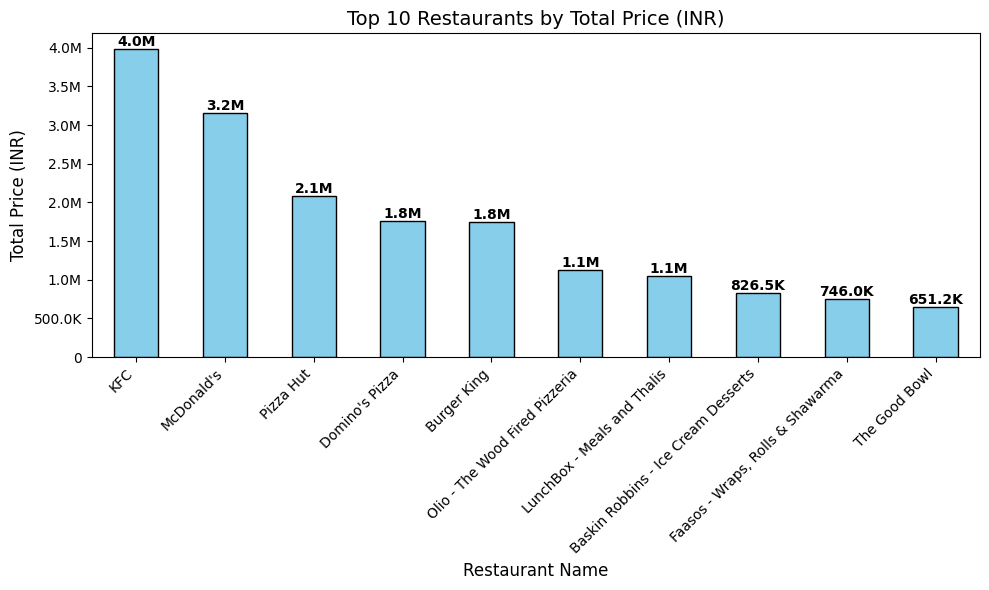

In [18]:
# Formatter function: show values in K/M
def format_inr(x, pos=None):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.1f}K'
    else:
        return f'{x:.0f}'

# Plot
plt.figure(figsize=(10,6))
ax = top_restaurants_data.plot(kind='bar', color='skyblue', edgecolor='black')

# Format Y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_inr))

# Add labels on top of bars
for p in ax.patches:
    value = p.get_height()
    ax.annotate(
        format_inr(value),                # formatted text
        (p.get_x() + p.get_width() / 2, value),  # position
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.title("Top 10 Restaurants by Total Price (INR)", fontsize=14)
plt.xlabel("Restaurant Name", fontsize=12)
plt.ylabel("Total Price (INR)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These restaurants demonstrate a significant presence in the market, either through a large menu, high-priced items, or a combination. Their sustained performance often indicates consistent quality and popularity among customers

Top Locations by Total Price

Understanding which location-city pairs generate the highest total price helps identify key areas of culinary activity. This can be valuable for business expansion or market analysis.

In [19]:
print(f"Number of unique locations: {len(df['location'].unique())}")
top_locations_data = df.groupby(['location', 'city'])['price_inr'].sum().sort_values(ascending=False).head(15)
print("\nTop 15 Location-City Pairs by Total Price (INR):")
print(top_locations_data)

Number of unique locations: 977

Top 15 Location-City Pairs by Total Price (INR):
location       city     
Gomti Nagar    Lucknow      661108.92
Nerul          Mumbai       570579.78
Vasant Kunj    Gurgaon      538517.30
Thane West     Mumbai       529090.14
Police Bazar   Shillong     517856.33
Whitefield     Bengaluru    512865.48
Yelahanka      Bengaluru    503351.43
Rohini         New Delhi    438849.04
Poonamallee    Chennai      424693.84
Jagatpura      Jaipur       409270.39
Solan Town     Shimla       397853.34
Thakurpukur    Kolkata      389532.81
Gangtok        Gangtok      377240.69
Mall Road      Shimla       358442.83
Shankar Nagar  Raipur       353404.27
Name: price_inr, dtype: float64


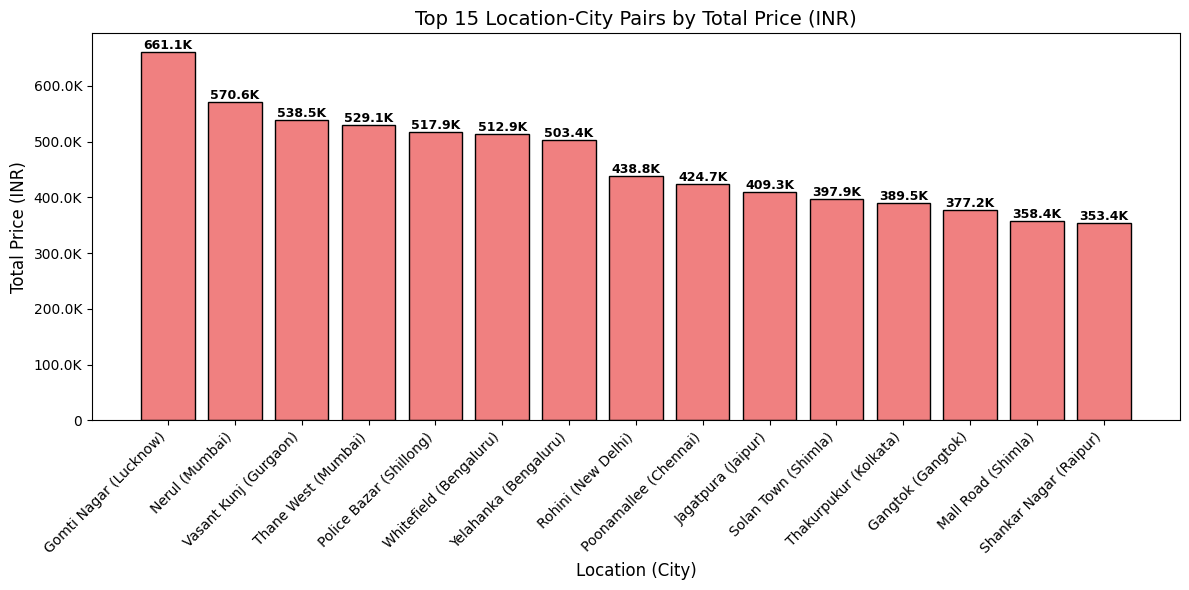

In [20]:
# Convert to DataFrame and create combined labels
top_df = top_locations_data.reset_index()
top_df.rename(columns={'price_inr': 'total_price'}, inplace=True)
top_df['label'] = top_df['location'] + " (" + top_df['city'] + ")"

# Plot
plt.figure(figsize=(12,6))
ax = plt.bar(top_df['label'], top_df['total_price'], color='lightcoral', edgecolor='black')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_inr))

# Add labels on top of bars
for bar, value in zip(ax, top_df['total_price']):
    plt.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height(),
        format_inr(value),
        ha='center', va='bottom', fontsize=9, fontweight='bold'
    )

plt.title("Top 15 Location-City Pairs by Total Price (INR)", fontsize=14)
plt.xlabel("Location (City)", fontsize=12)
plt.ylabel("Total Price (INR)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These location-city pairs represent vibrant culinary hubs. For anyone considering a new restaurant venture, these areas signify high existing demand and active food markets, making them potentially promising locations.

Top Restaurants within High-Activity Locations


To gain a deeper understanding of competition and popular choices within the most active areas, we visualize the top restaurants by total price within each of the top 15 locations identified previously. This offers granular insights into local market leaders.

C:\Users\shwet\AppData\Local\Temp\ipykernel_10548\338842815.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(7, 'price_inr'))


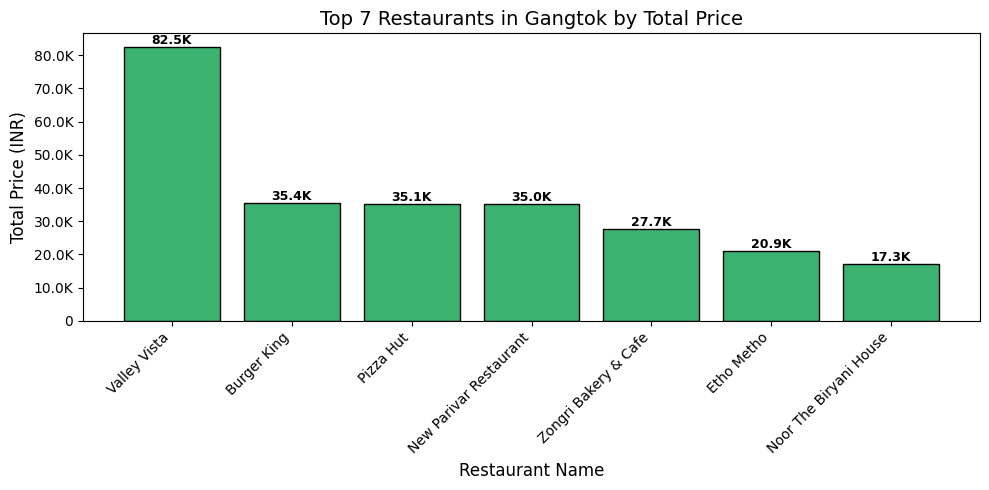

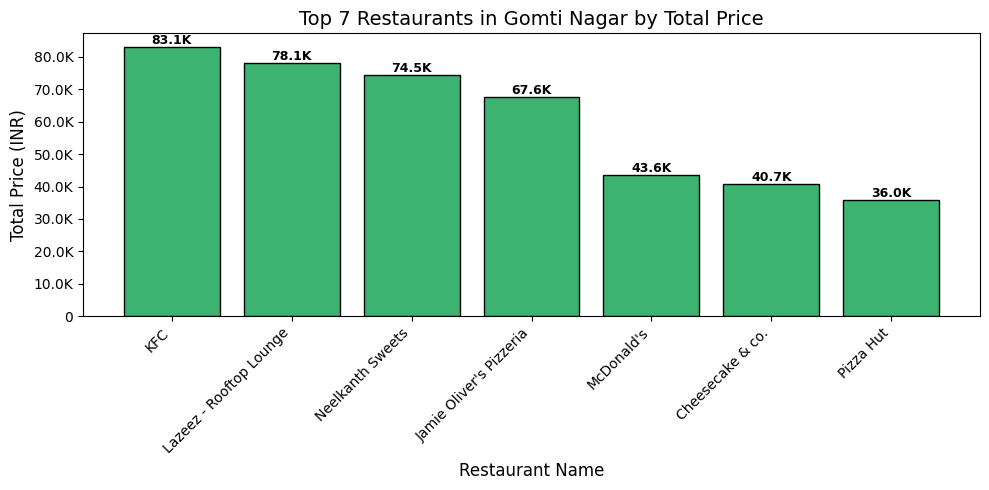

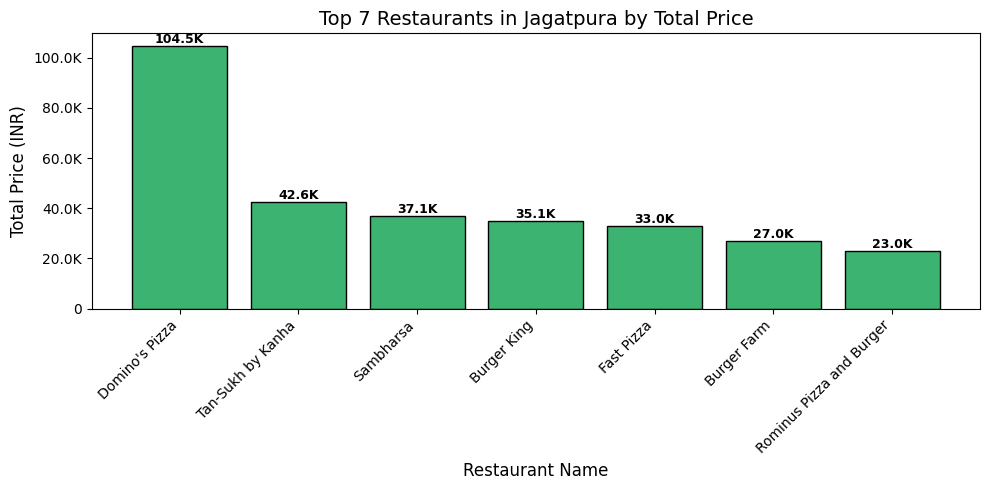

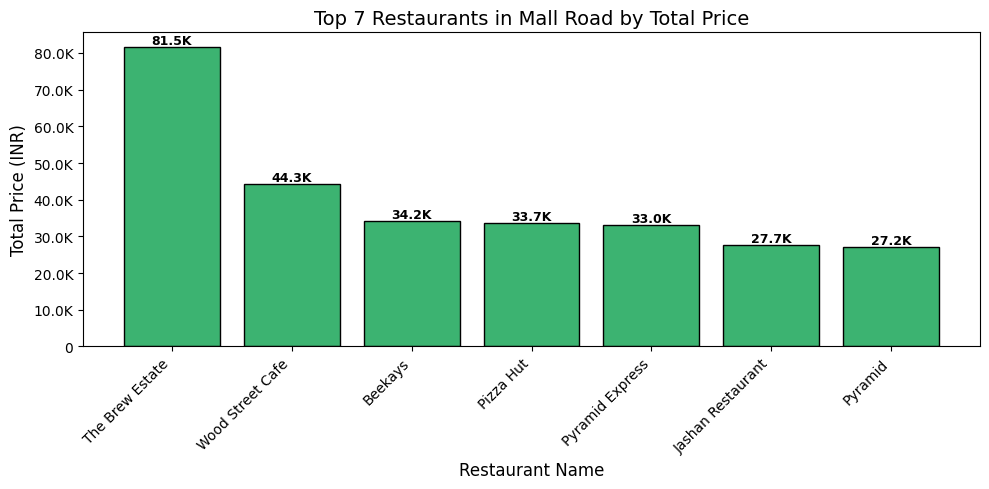

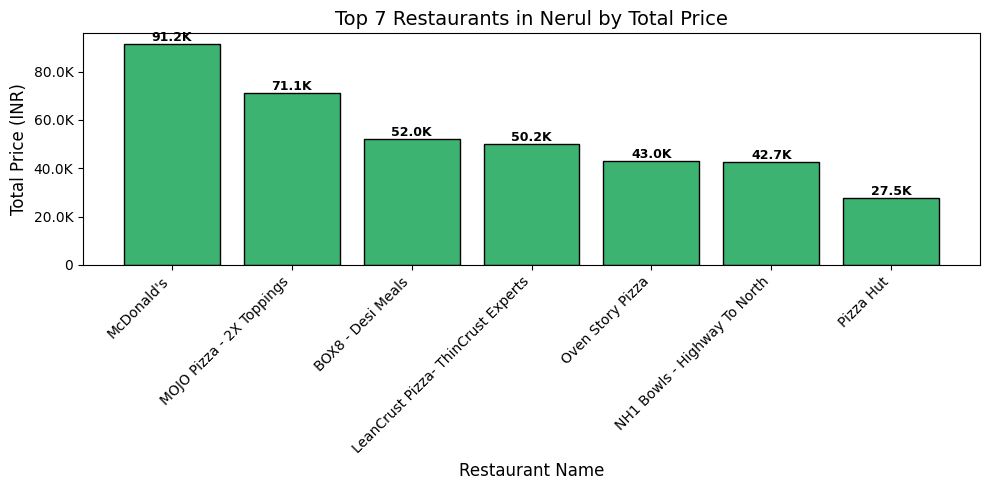

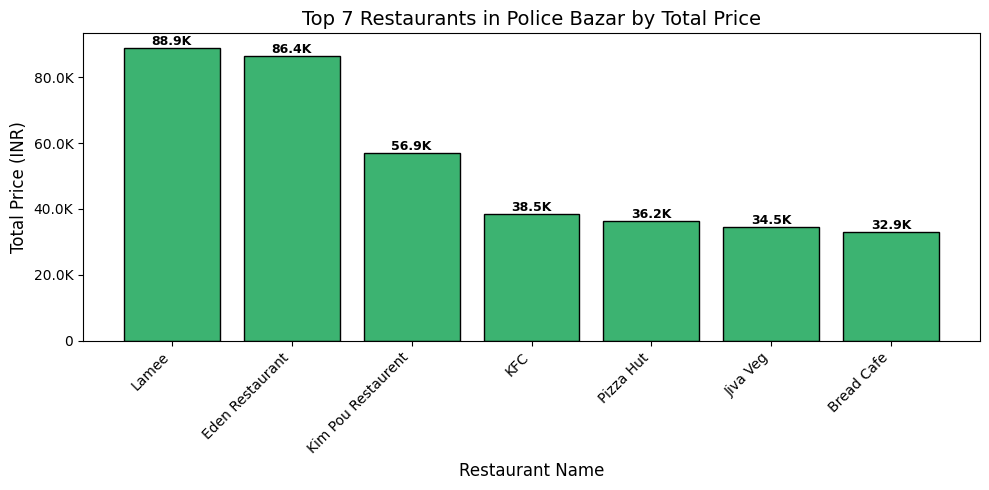

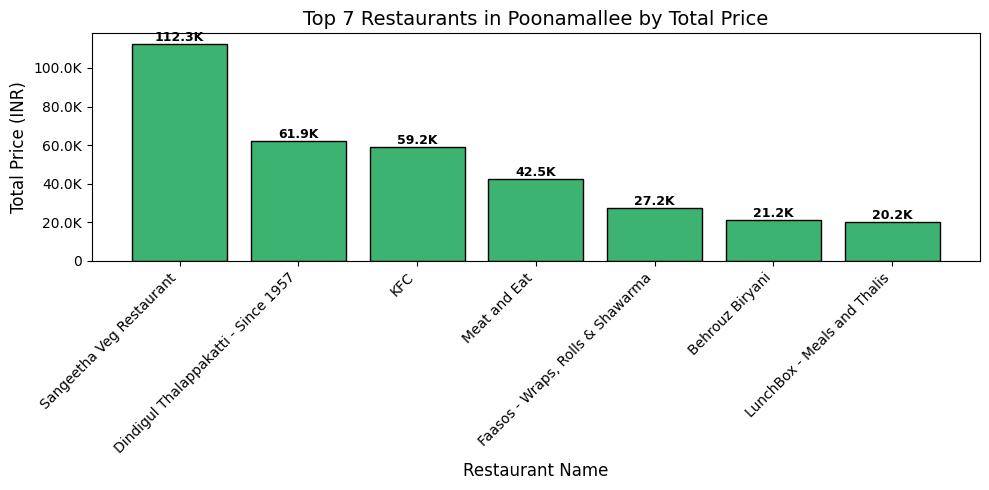

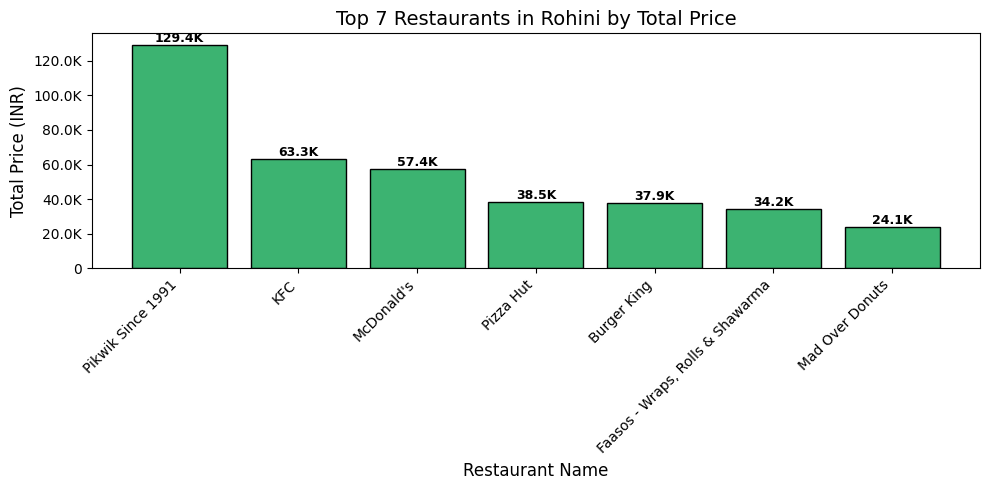

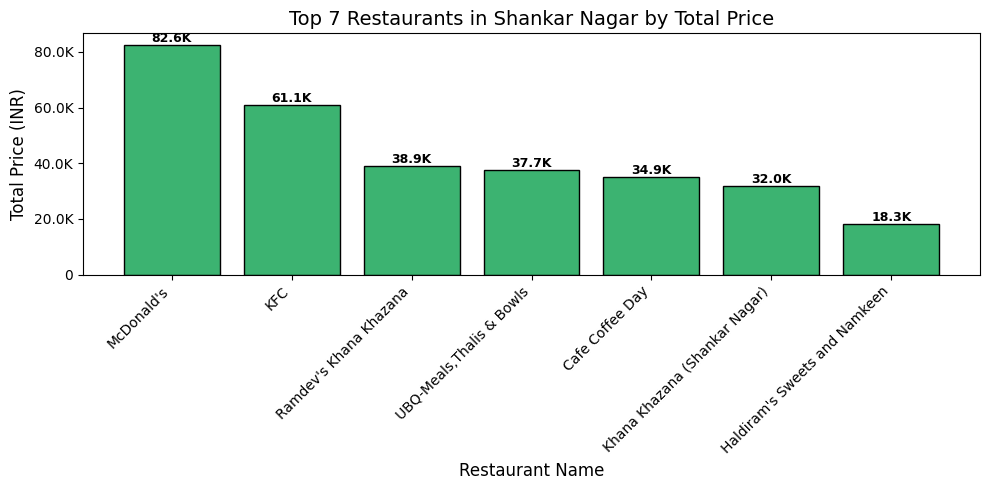

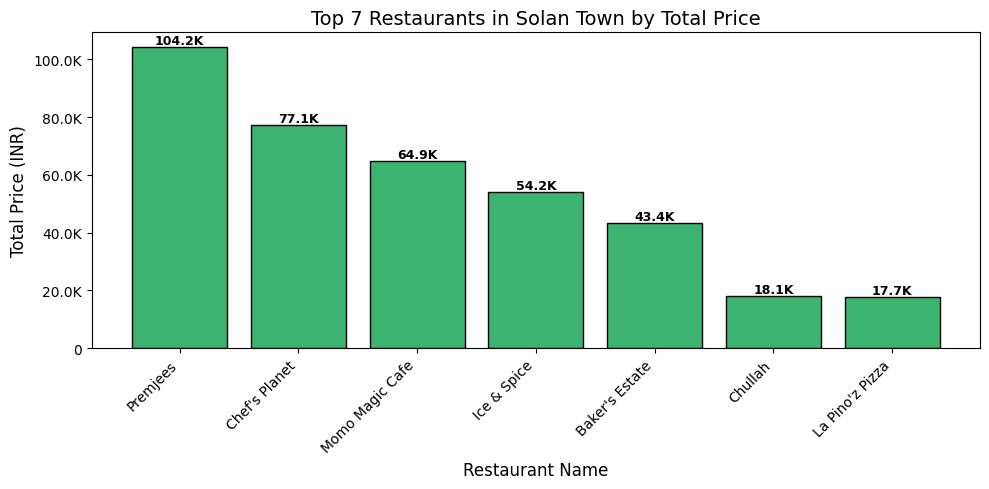

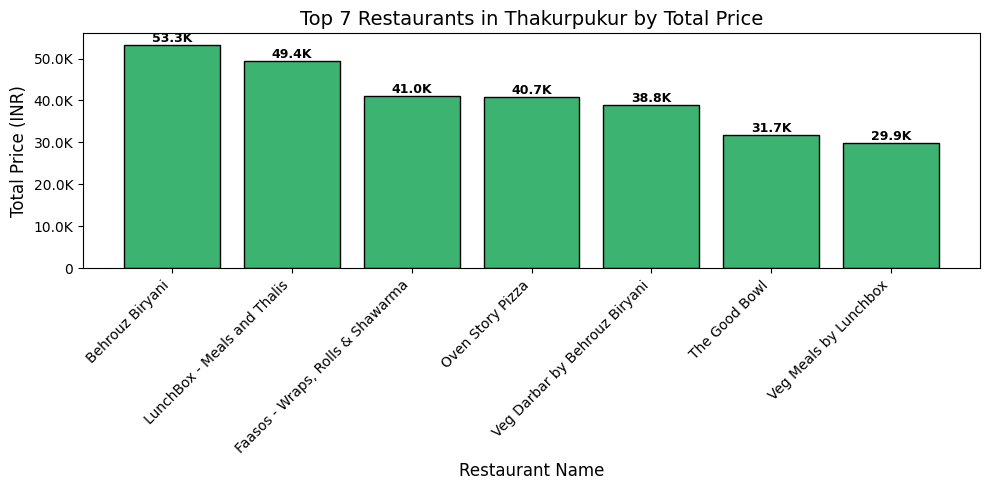

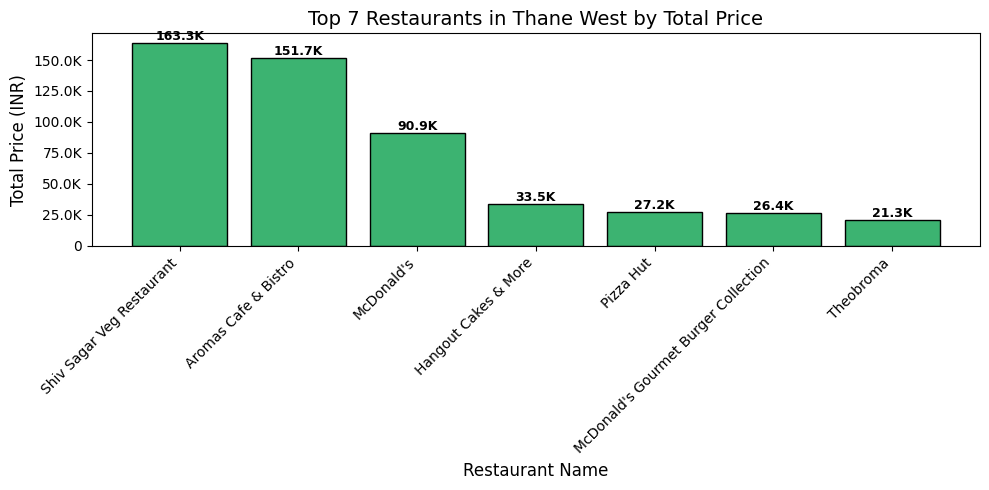

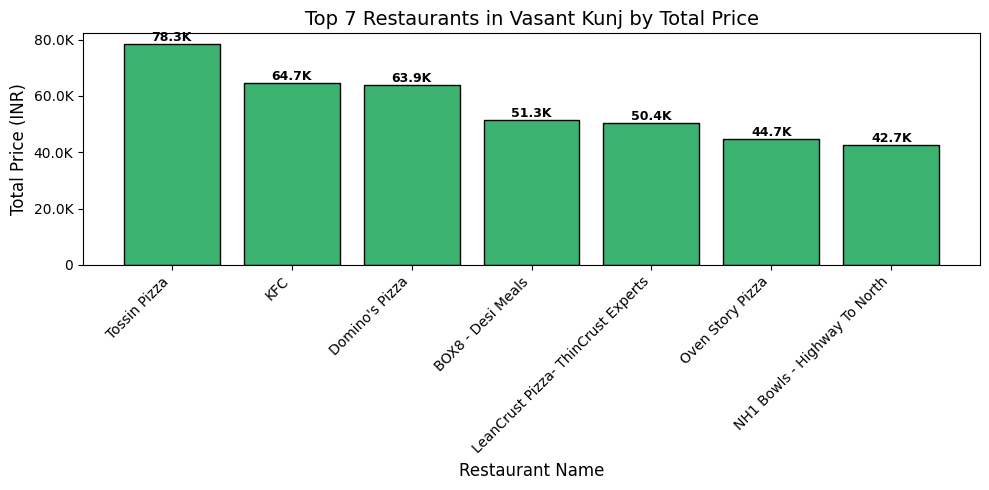

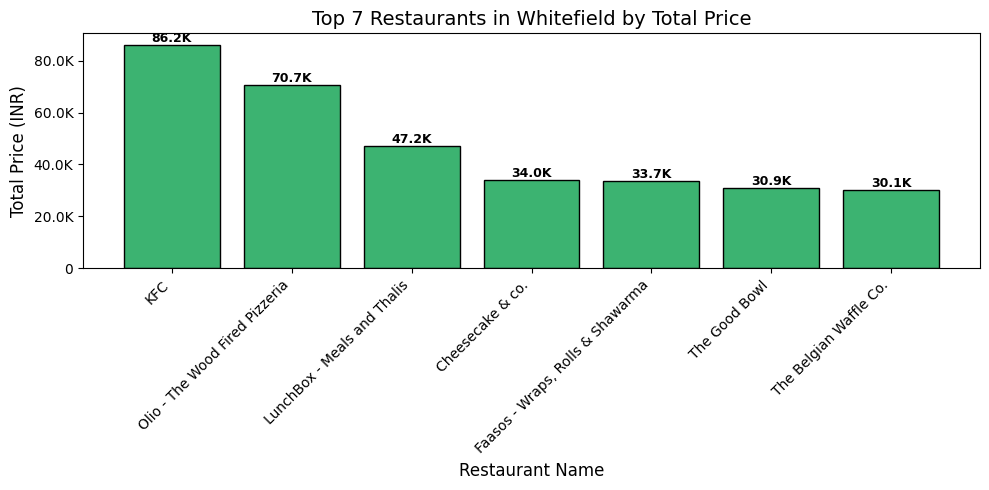

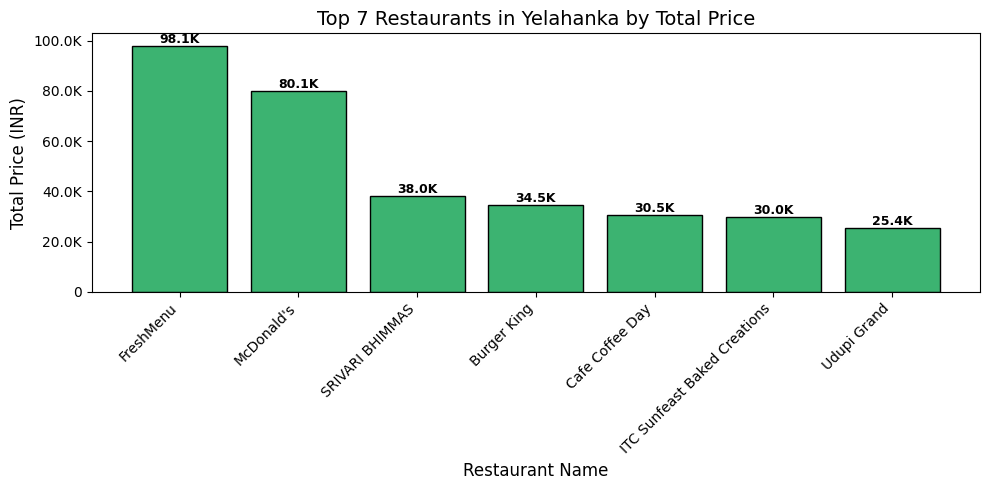

In [21]:
# Step 1: Top 15 locations by total price
top15_locs = (
    df.groupby('location')['price_inr']
      .sum()
      .sort_values(ascending=False)
      .head(15)
      .index
)

# Step 2: Group by location + restaurant and filter only top 15 locations
loc_rest = (
    df[df['location'].isin(top15_locs)]
      .groupby(['location', 'restaurant_name'])['price_inr']
      .sum()
      .reset_index()
)

# Step 3: Top 7 restaurants per location
top7_per_loc = (
    loc_rest.groupby('location', group_keys=False)
            .apply(lambda x: x.nlargest(7, 'price_inr'))
)

# Step 4: Plot top 7 restaurants for each of the top 15 locations
for loc, data in top7_per_loc.groupby('location'):
    plt.figure(figsize=(10,5))
    bars = plt.bar(data['restaurant_name'], data['price_inr'],
                   color='mediumseagreen', edgecolor='black')
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_inr))
    
    # Add labels
    for bar, value in zip(bars, data['price_inr']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 format_inr(value), ha='center', va='bottom',
                 fontsize=9, fontweight='bold')
    
    plt.title(f"Top 7 Restaurants in {loc} by Total Price", fontsize=14)
    plt.xlabel("Restaurant Name", fontsize=12)
    plt.ylabel("Total Price (INR)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

These detailed plots reveal the dominant players within specific high-demand localities. Aspiring restaurateurs can leverage this information to analyze local market preferences and tailor their menus to compete effectively or find niche opportunities.

Top-Rated Restaurants


Customer ratings are a crucial indicator of quality and satisfaction. We identify restaurants with the highest average ratings to highlight those consistently praised by users. We also check the total number of unique restaurants in the dataset.

In [22]:
print(f"Total unique restaurants in the dataset: {len(df['restaurant_name'].unique())}")
top_rated_restaurants = df.groupby('restaurant_name')['rating'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 Restaurants by Average Rating:")
print(top_rated_restaurants)

Total unique restaurants in the dataset: 993

Top 10 Restaurants by Average Rating:
restaurant_name
Jagannath Mandir Arna Prasad                 4.750000
Radhey Lal's Parampara Sweets                4.736905
Aryan Family's Delight                       4.642500
Alakapuri                                    4.642045
Hotel Al Reem                                4.637500
Paris Panini - Gourmet Sandwiches & Wraps    4.635294
Natural Ice Cream                            4.633333
Pizza Jalapenia (Uptown)                     4.600000
Panna Sweets & Restaurant                    4.580000
The Chicken Wagon                            4.548571
Name: rating, dtype: float64


### 6. Conclusion

This analysis provided a comprehensive look into the Swiggy restaurant data across India. We successfully:


- Cleaned and prepared the raw data for analysis.
- Engineered a rich feature for building a recommendation system.
- Developed a state-wise semantic recommendation system using SentenceTransformer and FAISS, enabling users to find relevant food options with natural language queries.
- Conducted an Exploratory Data Analysis (EDA), identifying:
- 1. Top-performing restaurants by total price.
- 2. High-activity location-city pairs, highlighting potential growth areas.
- 3. Key competitors within these active localities.
- 4. Highly-rated restaurants, indicative of customer satisfaction.


The insights gained from this notebook can be valuable for various stakeholders, from food enthusiasts seeking new culinary experiences to business analysts and prospective restaurateurs looking to understand market dynamics and identify strategic opportunities.